In [1]:
!pip install deap
#import some hub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Sequential,losses,optimizers,datasets

from math import floor
# import optimizers, losses
from tensorflow.keras import optimizers,losses 

     |████████████████████████████████| 160 kB 4.2 MB/s 


In [2]:
class MLPLayers:

    def __init__(self):

        self.initDataset()
    # Pre-processing of training data
    def preprocess(self,x,y):
        x = tf.reshape(x, [-1]) 
        return x,y
    # Build a dataset ,  Import a mnist dataset
    def initDataset(self):
        (self.X_train,self.y_train),(self.X_test,self.y_test) = datasets.mnist.load_data()
        
        self.X_train = tf.convert_to_tensor(self.X_train,dtype=tf.float32) / 255.
        self.X_test = tf.convert_to_tensor(self.X_test,dtype=tf.float32) / 255.

        self.y_train = tf.convert_to_tensor(self.y_train,dtype=tf.int32)
        self.y_test = tf.convert_to_tensor(self.y_test,dtype=tf.int32)
        self.y_train = tf.one_hot(self.y_train,depth=10)
        self.y_test = tf.one_hot(self.y_test,depth=10)

        self.train_db = tf.data.Dataset.from_tensor_slices((self.X_train,self.y_train))
        self.validation_db = tf.data.Dataset.from_tensor_slices((self.X_test,self.y_test))
        self.train_db = self.train_db.shuffle(1000).map(self.preprocess).batch(128)
        self.validation_db = self.validation_db.shuffle(1000).map(self.preprocess).batch(128)
    # Transforming chromosomes into tuple that can efficiently build networks
    def convertParams(self,params):
        if round(params[1]) <= 0:
            hiddenLayerSizes = round(params[0]),
        elif round(params[2]) <= 0:
            hiddenLayerSizes = (round(params[0]), round(params[1]))
        elif round(params[3]) <= 0:
            hiddenLayerSizes = (round(params[0]), round(params[1]), round(params[2]))
        else:
            hiddenLayerSizes = (round(params[0]), round(params[1]), round(params[2]), round(params[3]))

        return hiddenLayerSizes
    
    def getAccuracy(self,params):
    	#Transforming chromosomes into tuple that can efficiently build networks
        hiddenLayerSizes = self.convertParams(params)

        self.model = Sequential()
        #build network
        for l in hiddenLayerSizes:
            self.model.add(layers.Dense(l,activation='relu'))
        self.model.add(layers.Dense(10,activation='relu'))
        self.model.build(input_shape=(4,28*28))
        self.model.summary()
        self.model.compile(optimizer=optimizers.Adam(lr=0.01),
                loss=losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
        # Specify the training set as db, the validation set as val_db, train 5 epochs, and validate every 1 epoch
        history = self.model.fit(self.train_db, epochs=5, validation_data=self.validation_db, validation_freq=1,verbose=2)
        
        #return  the validation accuracy after the last epoch training for fitness evaluation
        return history.history['val_accuracy'][-1]

    # Back the validation accuracy after the last epoch training for fitness evaluation
    def testLayer(self):
        # Create a 5-layer fully connected layer network
        network = Sequential([layers.Dense(256, activation='relu'),
                            layers.Dense(128, activation='relu'),
                            layers.Dense(64, activation='relu'),
                            layers.Dense(32, activation='relu'),
                            layers.Dense(10)])
        network.build(input_shape=(4, 28*28))
        network.summary()

        # Using Adam optimizer, set the learning rate to 0.01; which contains Softmax
        network.compile(optimizer=optimizers.Adam(lr=0.01),
                loss=losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'] # Set the measurement index as accuracy rate
        )


        # Name the training set as db and the validation set as val_db, train 5 epochs and validate every 1 epoch
        history = network.fit(self.train_db, epochs=5, validation_data=self.validation_db, validation_freq=1,verbose=2)
        
        #print result 
        print(history.history['val_accuracy'][-1])
    
    def formatParams(self, params):
        return "'hidden_layer_sizes'={}".format(self.convertParams(params))


In [3]:
# deap combines the data structures and tools needed to implement the most common evolutionary computational techniques, including the genetic algorithm we are using here
from deap import base, tools, creator, algorithms

import random
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


# Create instances of the MlpLayersTest class for testing various combinations of hidden layer architectures
test = MLPLayers()


# First set the upper and lower bounds for each float value representing a hidden layer. 
# The first hidden layer is in the range [100, 300], while the remaining layers start with negative values, increasing the chance of terminating the layers at.
BOUNDS_LOW = [100,-25,-50,-75]
BOUNDS_HIGH = [300,200,100,50]

NUM_OF_PARAMS = len(BOUNDS_LOW)

#Set some hyperparameters related to the genetic algorithm:
POPULATION_SIZE = 50 # population size 
P_CROSSOVER = 0.9 # crossover probility
P_MUTATION = 0.5 # mutation probility
MAX_GENERATIONS = 20 
HALL_OF_FAME_SIZE = 5 # Number of units to be retained
CROWDING_FACTOR = 10.0 

toolbox = base.Toolbox()

# Define the maximization fitness strategy:
creator.create("FitnessMax",base.Fitness,weights=(1.0,))

# Create individual classes based on lists:
creator.create("Individual",list,fitness=creator.FitnessMax)

# Since the solution is represented by a series of floating point values in different intervals, we use the following loop and create a separate toolbox operator (layer_size_attribute) for each interval to generate random floating point values in the appropriate range::
for i in range(NUM_OF_PARAMS):
    #"layer_size_attribute_0","layer_size_attribute_1"...
    toolbox.register("layer_size_attribute_"+str(i),
            random.uniform,
            BOUNDS_LOW[i],
            BOUNDS_HIGH[i])

# Create a tuple containing the individual floating point generators we just created for each hidden layer:
layer_size_attributes = ()
for i in range(NUM_OF_PARAMS):
    layer_size_attributes = layer_size_attributes + (toolbox.__getattribute__("layer_size_attribute_"+str(i)),)

# Use this created tuple in conjunction with deap's built-in initCycle() operator to create a new individualCreator operator that combines randomly generated hidden layer values to populate a single instance
toolbox.register("individualCreator",tools.initCycle,creator.Individual,layer_size_attributes,n=1)

# Define the population creation operator:
toolbox.register("populationCreator",tools.initRepeat,list,toolbox.individualCreator)

# use getAccuracy()
def classificationAccuracy(individual):
    return test.getAccuracy(individual),

# Toolbox class for creating genetic algorithms provided by the deap framework. toolbox is used as a container for functions (or operations) that can be used to create new operators through the aliasing mechanism and customizing existing functions.
toolbox.register("evaluate",classificationAccuracy)

# Definition of genetic operators: for selection operators, use tournament selection of tournament size 2, use crossover and mutation operators specifically for bounded floating list chromosomes, and provide defined upper and lower bounds for them:
toolbox.register("select",tools.selTournament,tournsize=2)
# crossover
toolbox.register("mate",tools.cxSimulatedBinaryBounded,low=BOUNDS_LOW,up=BOUNDS_HIGH,eta=CROWDING_FACTOR)
# mutation
toolbox.register("mutate",tools.mutPolynomialBounded,low=BOUNDS_LOW,up=BOUNDS_HIGH,eta=CROWDING_FACTOR,indpb=1.0/NUM_OF_PARAMS)



11501568/11490434 [==============================] - 0s 0us/step


In [4]:

def eaSimpleWithElitism(population,
			toolbox,
            cxpb,
            mutpb,
            ngen,
            stats=None,
            halloffame=None,
            verbose=__debug__):
    """The elitist selection is used to implement the elitist mechanism. Individuals contained in the Hall of Fame wheat are injected directly into the next generation and are unaffected by the genetic operators of selection, crossover and mutation.
    """
    
    logbook = tools.Logbook()# For monitoring algorithm operation, and statistical data
    logbook.header = ['gen','nevals'] + (stats.fields if stats else [])

    # calculate individual fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate,invalid_ind)
    for ind,fit in zip(invalid_ind,fitnesses):
        ind.fitness.values = fit
    
    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")
	#Update elite members
    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0,nevals=len(invalid_ind),**record)
    if verbose:
        print(logbook.stream)
    
    #start 
    for gen in range(1,ngen + 1):
        #Number of selected individuals = number of individuals in the population - elite members
        offspring = toolbox.select(population,len(population) - hof_size)

        #Population renewal to the next generation
        offspring = algorithms.varAnd(offspring,toolbox,cxpb,mutpb)

        #calculate individual fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate,invalid_ind)
        for ind,fit in zip(invalid_ind,fitnesses):
            ind.fitness.values = fit
        
        # Add elite members to the current generation
        offspring.extend(halloffame.items)

        #update elite members
        halloffame.update(offspring)

        #Use current to instead
        population[:] = offspring

        # Append current statistics to the log
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen,nevals=len(invalid_ind),**record)
        if verbose:
            print(logbook.stream)
        
    return population,logbook


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (4, 102)                  80070     
                                                                 
 dense_1 (Dense)             (4, 138)                  14214     
                                                                 
 dense_2 (Dense)             (4, 10)                   1390      
                                                                 
Total params: 95,674
Trainable params: 95,674
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


流式输出内容被截断，只能显示最后 5000 行内容。
 dense_3152 (Dense)          (4, 31)                   8587      
                                                                 
 dense_3153 (Dense)          (4, 57)                   1824      
                                                                 
 dense_3154 (Dense)          (4, 10)                   580       
                                                                 
Total params: 227,651
Trainable params: 227,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
469/469 - 2s - loss: 0.2465 - accuracy: 0.9271 - val_loss: 0.1502 - val_accuracy: 0.9545 - 2s/epoch - 4ms/step
Epoch 2/5
469/469 - 1s - loss: 0.1251 - accuracy: 0.9645 - val_loss: 0.1557 - val_accuracy: 0.9572 - 1s/epoch - 3ms/step
Epoch 3/5
469/469 - 1s - loss: 0.0978 - accuracy: 0.9720 - val_loss: 0.1291 - val_accuracy: 0.9668 - 1s/epoch - 3ms/step
Epoch 4/5
469/469 - 1s - loss: 0.0868 - accuracy: 0.9751 - val_loss: 0.1188 

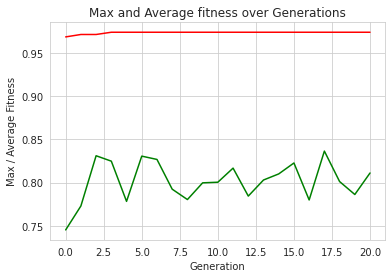

Model: "sequential_897"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3960 (Dense)          (4, 256)                  200960    
                                                                 
 dense_3961 (Dense)          (4, 128)                  32896     
                                                                 
 dense_3962 (Dense)          (4, 64)                   8256      
                                                                 
 dense_3963 (Dense)          (4, 32)                   2080      
                                                                 
 dense_3964 (Dense)          (4, 10)                   330       
                                                                 
Total params: 244,522
Trainable params: 244,522
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
469/469 - 2s - loss: 0.2729 - accura

In [5]:
def main():
    #Create initial populations:
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # Register the statistics to be listened to:
    stats = tools.Statistics(lambda ind:ind.fitness.values)
    stats.register("max",np.max)
    stats.register("avg",np.mean)

    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    #start
    population,logbook = eaSimpleWithElitism(population,toolbox,
            cxpb=P_CROSSOVER,mutpb=P_MUTATION,
            ngen=MAX_GENERATIONS,
            stats=stats,halloffame=hof,verbose=True)
    
    # print 
    print("- Best solution is: ",test.formatParams(hof.items[0]),", accuracy = ",hof.items[0].fitness.values[0])

    maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

    # draw
    sns.set_style("whitegrid")
    plt.plot(maxFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Max / Average Fitness')
    plt.title('Max and Average fitness over Generations')
    plt.show()
	# compare with network structure created according to experience
    test.testLayer()

if __name__ == "__main__":
    main()
